# Comparação da Melhor Consumo de Bateria entre timesteps


In [1]:
# Importa a biblioteca Matplotlib, que é usada para criar visualizações gráficas de dados.
# O módulo 'pyplot' fornece uma interface semelhante à do MATLAB para criar gráficos.
import matplotlib.pyplot as plt

# Importa a biblioteca Z3, que é um solver SMT (Satisfiability Modulo Theories) usado para resolver problemas lógicos e de otimização.
# 'from z3 import *' importa todas as funções e classes do Z3 diretamente no escopo global do código,
# permitindo trabalhar com expressões lógicas, variáveis simbólicas e constraints matemáticas.
from z3 import *

## Configuração do Grid do Armazém e Posição Inicial do Drone


In [2]:
# Definindo os parâmetros que podem ser editados de acordo com a necessidade
num_rows = 4       # Número de "linhas" ou grupos de coordenadas no eixo X (quantidade de linhas no grid do armazém)
num_columns = 5    # Número de colunas de coordenadas no eixo Y (quantidade de colunas no grid do armazém)
x_step = 2         # Distância entre as "linhas" no eixo X (define o espaçamento horizontal entre os pontos)
x_offset = 3       # Deslocamento (offset) inicial no eixo X (define onde a primeira linha do grid começa no eixo X)
y_offset = 1       # Deslocamento (offset) inicial no eixo Y (define onde a primeira coluna do grid começa no eixo Y)

# Lista para armazenar todas as coordenadas do armazém
warehouse = []  # Inicializa uma lista vazia que armazenará todas as coordenadas dos pontos no armazém

# Criação das coordenadas do armazém (grid de posições)
for i in range(num_rows):  # Loop externo que percorre as linhas (grupos no eixo X)
    # 'i' representa o índice de cada linha que será criada
    for j in range(num_columns):  # Loop interno que percorre as colunas (grupos no eixo Y)
        # 'j' representa o índice de cada coluna dentro da linha correspondente
        
        x = x_step * i + x_offset  # Cálculo da coordenada X: multiplica o índice da linha pelo espaçamento e adiciona o deslocamento inicial
        y = j + y_offset           # Cálculo da coordenada Y: usa o índice da coluna e adiciona o deslocamento inicial
        
        warehouse.append((x, y))   # Adiciona a tupla (x, y) à lista de coordenadas do armazém

# Exibe a lista de coordenadas geradas para o armazém
print("Coordenadas do armazém:", warehouse)

# Definição da posição inicial do drone
drone = (0, 0)  # O drone começa na posição (0,0), mas esse valor pode ser alterado conforme necessário
print("Posição inicial do drone:", drone)


Coordenadas do armazém: [(3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5)]
Posição inicial do drone: (0, 0)


## Visualização do Grid do Armazém e da Posição Inicial do Drone


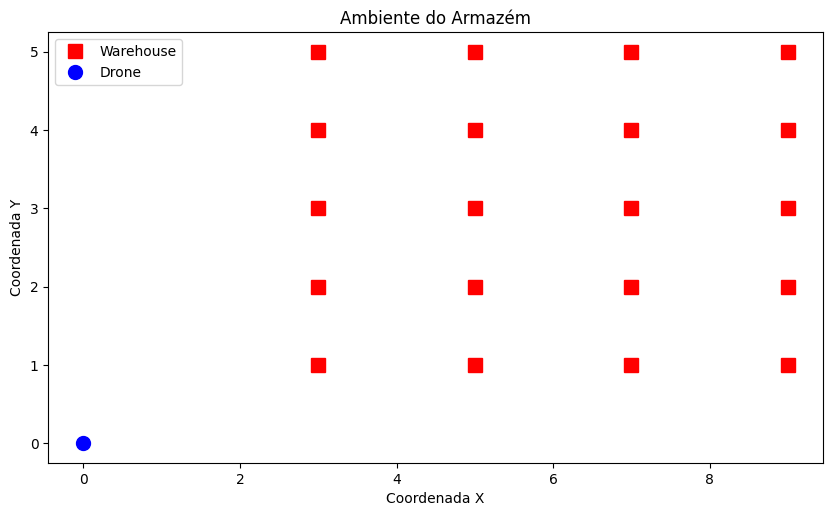

In [3]:
# Criação da figura e do eixo do gráfico
fig, ax = plt.subplots(figsize=(10, 6))  
# 'fig' representa a figura do Matplotlib, que contém o gráfico
# 'ax' é o eixo do gráfico onde os elementos serão desenhados
# figsize=(10, 6) define o tamanho da figura em polegadas (largura x altura)

# Plotagem dos pontos representando as coordenadas do armazém
ax.plot(
    [x for x, y in warehouse],  # Extrai todas as coordenadas X da lista warehouse
    [y for x, y in warehouse],  # Extrai todas as coordenadas Y da lista warehouse
    'rs',  # Define o marcador como um quadrado vermelho ('r' = red, 's' = square)
    markersize=10,  # Define o tamanho dos marcadores no gráfico
    label='Warehouse'  # Define o rótulo para a legenda do gráfico
)

# Plotagem da posição inicial do drone
ax.plot(
    drone[0],  # Coordenada X do drone
    drone[1],  # Coordenada Y do drone
    'bo',  # Define o marcador como um círculo azul ('b' = blue, 'o' = circle)
    markersize=10,  # Define o tamanho do marcador do drone
    label='Drone'  # Define o rótulo para a legenda do gráfico
)

# Adiciona um título ao gráfico
ax.set_title('Ambiente do Armazém')

# Define os rótulos dos eixos do gráfico
ax.set_xlabel('Coordenada X')  # Nome do eixo X
ax.set_ylabel('Coordenada Y')  # Nome do eixo Y

# Configura os eixos para ter a mesma escala, garantindo que as distâncias sejam proporcionais
ax.set_aspect('equal')

# Exibe a legenda no gráfico, utilizando os rótulos definidos nos plots
ax.legend()

# Exibe o gráfico na tela
plt.show()

# Melhor bateria com menor timesteps

unsat timesteps: 1
unsat timesteps: 2
unsat timesteps: 3
unsat timesteps: 4
unsat timesteps: 5
unsat timesteps: 6
unsat timesteps: 7
unsat timesteps: 8
unsat timesteps: 9
unsat timesteps: 10
unsat timesteps: 11
unsat timesteps: 12
unsat timesteps: 13
unsat timesteps: 14
unsat timesteps: 15
unsat timesteps: 16
unsat timesteps: 17
unsat timesteps: 18
unsat timesteps: 19
unsat timesteps: 20
unsat timesteps: 21
unsat timesteps: 22
unsat timesteps: 23
unsat timesteps: 24
unsat timesteps: 25
unsat timesteps: 26
unsat timesteps: 27
unsat timesteps: 28
unsat timesteps: 29
unsat timesteps: 30
unsat timesteps: 31
sat timesteps: 32
Solução viável encontrada com 32 timesteps.

Trajetória com maior bateria final: 35

Trajetória ótima:
Passo 0: Posição (0, 0), Bateria 100
Passo 1: Posição (1, 1), Bateria 97
Passo 2: Posição (2, 1), Bateria 95
Passo 3: Posição (3, 1), Bateria 93
Passo 4: Posição (4, 1), Bateria 91
Passo 5: Posição (5, 1), Bateria 89
Passo 6: Posição (6, 1), Bateria 87
Passo 7: Posiçã

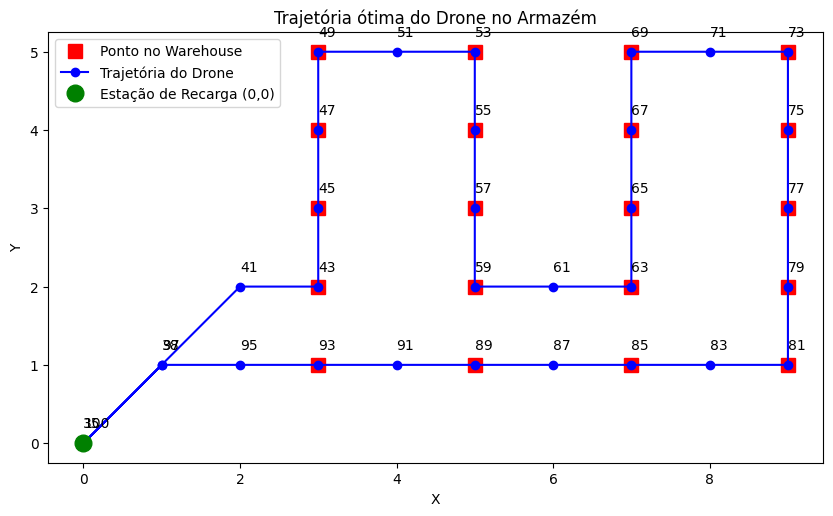

In [4]:
from z3 import *  # Importa todas as funções, classes e objetos do módulo Z3 para resolução de problemas lógicos e de restrições
import matplotlib.pyplot as plt  # Importa o módulo pyplot da biblioteca matplotlib para criação e exibição de gráficos, renomeando-o como plt

def find_minimum_timesteps(max_timesteps, bmax, gridx, gridy, warehouse):  # Define a função que encontra o menor número de timesteps em que existe uma solução viável
    """
    Procura, com um solver simples, o menor número de timesteps em que
    existe uma solução viável que visita todos os pontos do warehouse.
    """
    for timesteps in range(1, max_timesteps + 1):  # Itera de 1 até max_timesteps para testar quantos timesteps são necessários
        s = Solver()  # Cria uma instância do Solver do Z3 para resolver as restrições definidas

        # Declaração das variáveis para cada timestep
        PGx = [Int(f'pgx_{k}') for k in range(timesteps)]  # Cria uma lista de variáveis inteiras para representar a posição x do drone em cada timestep
        PGy = [Int(f'pgy_{k}') for k in range(timesteps)]  # Cria uma lista de variáveis inteiras para representar a posição y do drone em cada timestep
        Bat = [Int(f'bat_{k}') for k in range(timesteps)]  # Cria uma lista de variáveis inteiras para representar o nível de bateria do drone em cada timestep

        # Restrições de limites para as variáveis
        for b in Bat:  # Para cada variável de bateria na lista Bat
            s.add(And(b >= 1, b <= bmax))  # Adiciona a restrição de que o valor da bateria deve estar entre 1 e bmax (inclusive)
        for x in PGx:  # Para cada variável de posição x na lista PGx
            s.add(And(x >= 0, x <= gridx))  # Adiciona a restrição de que x deve estar entre 0 e gridx (inclusive)
        for y in PGy:  # Para cada variável de posição y na lista PGy
            s.add(And(y >= 0, y <= gridy))  # Adiciona a restrição de que y deve estar entre 0 e gridy (inclusive)

        # Condições iniciais
        s.add(PGx[0] == 0, PGy[0] == 0, Bat[0] == bmax)  # Define as condições iniciais: posição (0,0) e bateria inicial igual a bmax

        # Restrições de movimento e consumo de bateria
        for k in range(1, timesteps):  # Itera pelos timesteps a partir do segundo (índice 1)
            s.add(Or(PGx[k] == PGx[k-1] + 1, PGx[k] == PGx[k-1] - 1, PGx[k] == PGx[k-1]))  # Restringe o movimento em x: o drone pode avançar, recuar ou permanecer no mesmo x
            s.add(Or(PGy[k] == PGy[k-1] + 1, PGy[k] == PGy[k-1] - 1, PGy[k] == PGy[k-1]))  # Restringe o movimento em y: o drone pode subir, descer ou permanecer no mesmo y
            
            # Impede que o drone permaneça na mesma posição
            s.add(Not(And(PGx[k] == PGx[k-1], PGy[k] == PGy[k-1])))  # Garante que o drone se mova, impedindo que ambas as coordenadas se mantenham inalteradas
            
            s.add(If(  # Adiciona uma restrição condicional para definir o consumo de bateria com base no movimento realizado
                Or(  # Verifica se o movimento é diagonal (mudança em ambas as coordenadas)
                    And(PGx[k] == PGx[k-1] + 1, PGy[k] == PGy[k-1] + 1),  # Movimento diagonal: para cima à direita
                    And(PGx[k] == PGx[k-1] - 1, PGy[k] == PGy[k-1] - 1),  # Movimento diagonal: para baixo à esquerda
                    And(PGx[k] == PGx[k-1] + 1, PGy[k] == PGy[k-1] - 1),  # Movimento diagonal: para baixo à direita
                    And(PGx[k] == PGx[k-1] - 1, PGy[k] == PGy[k-1] + 1)   # Movimento diagonal: para cima à esquerda
                ),
                Bat[k] == Bat[k-1] - 3,  # Se o movimento for diagonal, a bateria diminui em 3 unidades
                If(  # Caso contrário, verifica se o movimento é horizontal ou vertical
                    Or(  # Verifica os movimentos horizontais ou verticais
                        And(PGx[k] == PGx[k-1] + 1, PGy[k] == PGy[k-1]),  # Movimento horizontal: para a direita
                        And(PGx[k] == PGx[k-1] - 1, PGy[k] == PGy[k-1]),  # Movimento horizontal: para a esquerda
                        And(PGx[k] == PGx[k-1], PGy[k] == PGy[k-1] - 1),  # Movimento vertical: para baixo
                        And(PGx[k] == PGx[k-1], PGy[k] == PGy[k-1] + 1)   # Movimento vertical: para cima
                    ),
                    Bat[k] == Bat[k-1] - 2,  # Se o movimento for horizontal ou vertical, a bateria diminui em 2 unidades
                    Bat[k] == Bat[k-1]  # Caso nenhum movimento seja identificado, a bateria permanece a mesma
                )
            ))  # Finaliza a restrição condicional de consumo de bateria

        # Cada ponto no warehouse deve ser visitado em algum timestep
        for (x, y) in warehouse:  # Itera por cada ponto (x, y) definido no warehouse
            s.add(Or([And(PGx[k] == x, PGy[k] == y) for k in range(timesteps)]))  # Garante que cada ponto seja visitado em pelo menos um timestep
        
        # Adicionando restrição para que, no último timestep, o drone retorne ao ponto inicial (0,0)
        s.add(PGx[timesteps - 1] == 0)  # Restringe que a posição x no último timestep seja 0 (retorno à origem)
        s.add(PGy[timesteps - 1] == 0)  # Restringe que a posição y no último timestep seja 0 (retorno à origem)
        
        if s.check() == sat:  # Verifica se o solver encontrou uma solução viável para o número atual de timesteps
            print(s.check(), "timesteps:", timesteps)  # Imprime o resultado da verificação e o número de timesteps testados
            return timesteps  # Retorna o menor número de timesteps viável
        else:
            print(s.check(), "timesteps:", timesteps)  # Imprime o resultado da verificação (geralmente unsat) para o número atual de timesteps
    return None  # Se nenhuma solução viável for encontrada até max_timesteps, retorna None

def optimize_battery(timesteps, bmax, gridx, gridy, warehouse):  # Define a função que, com um número fixo de timesteps, otimiza a bateria final
    """
    Com um número fixo de timesteps (mínimo encontrado), configura as
    restrições e usa o Optimize para maximizar a bateria no último passo.
    """
    opt = Optimize()  # Cria uma instância do otimizador do Z3 para resolver o problema com objetivo

    PGx = [Int(f'pgx_{k}') for k in range(timesteps)]  # Cria uma lista de variáveis inteiras para a posição x em cada timestep
    PGy = [Int(f'pgy_{k}') for k in range(timesteps)]  # Cria uma lista de variáveis inteiras para a posição y em cada timestep
    Bat = [Int(f'bat_{k}') for k in range(timesteps)]  # Cria uma lista de variáveis inteiras para o nível de bateria em cada timestep

    for b in Bat:  # Para cada variável de bateria
        opt.add(And(b >= 1, b <= bmax))  # Adiciona a restrição de que a bateria deve estar entre 1 e bmax
    for x in PGx:  # Para cada variável de posição x
        opt.add(And(x >= 0, x <= gridx))  # Adiciona a restrição de que x deve estar entre 0 e gridx
    for y in PGy:  # Para cada variável de posição y
        opt.add(And(y >= 0, y <= gridy))  # Adiciona a restrição de que y deve estar entre 0 e gridy

    opt.add(PGx[0] == 0, PGy[0] == 0, Bat[0] == bmax)  # Define as condições iniciais: posição (0,0) e bateria inicial igual a bmax

    # Restrições de movimento e consumo de bateria
    for k in range(1, timesteps):  # Itera pelos timesteps a partir do segundo para definir os movimentos
        # Restrições de movimento permitidas para cada coordenada
        opt.add(Or(PGx[k] == PGx[k-1] + 1, PGx[k] == PGx[k-1] - 1, PGx[k] == PGx[k-1]))  # Restringe o movimento em x: pode avançar, recuar ou permanecer no mesmo valor
        opt.add(Or(PGy[k] == PGy[k-1] + 1, PGy[k] == PGy[k-1] - 1, PGy[k] == PGy[k-1]))  # Restringe o movimento em y: pode subir, descer ou permanecer no mesmo valor
        
        # Impede que o drone permaneça parado (ambas as coordenadas iguais ao timestep anterior)
        opt.add(Not(And(PGx[k] == PGx[k-1], PGy[k] == PGy[k-1])))  # Garante que o drone se mova em cada timestep

        # Restrições de consumo de bateria com base no tipo de movimento
        opt.add(If(  # Adiciona uma restrição condicional para definir o consumo de bateria
            Or(  # Verifica se o movimento é diagonal (mudança em ambas as coordenadas)
                And(PGx[k] == PGx[k-1] + 1, PGy[k] == PGy[k-1] + 1),  # Diagonal: para cima à direita
                And(PGx[k] == PGx[k-1] - 1, PGy[k] == PGy[k-1] - 1),  # Diagonal: para baixo à esquerda
                And(PGx[k] == PGx[k-1] + 1, PGy[k] == PGy[k-1] - 1),  # Diagonal: para baixo à direita
                And(PGx[k] == PGx[k-1] - 1, PGy[k] == PGy[k-1] + 1)   # Diagonal: para cima à esquerda
            ),
            Bat[k] == Bat[k-1] - 3,  # Se o movimento for diagonal, a bateria diminui em 3 unidades
            If(  # Caso contrário, verifica se o movimento é horizontal ou vertical
                Or(  # Verifica os movimentos horizontais ou verticais
                    And(PGx[k] == PGx[k-1] + 1, PGy[k] == PGy[k-1]),  # Horizontal: para a direita
                    And(PGx[k] == PGx[k-1] - 1, PGy[k] == PGy[k-1]),  # Horizontal: para a esquerda
                    And(PGx[k] == PGx[k-1], PGy[k] == PGy[k-1] - 1),  # Vertical: para baixo
                    And(PGx[k] == PGx[k-1], PGy[k] == PGy[k-1] + 1)   # Vertical: para cima
                ),
                Bat[k] == Bat[k-1] - 2,  # Se o movimento for horizontal ou vertical, a bateria diminui em 2 unidades
                Bat[k] == Bat[k-1]  # Caso nenhum dos movimentos seja realizado, a bateria permanece a mesma
            )
        ))  # Finaliza a restrição condicional para o consumo de bateria

    for (x, y) in warehouse:  # Itera por cada ponto (x, y) do warehouse
        opt.add(Or([And(PGx[k] == x, PGy[k] == y) for k in range(timesteps)]))  # Garante que cada ponto do warehouse seja visitado em pelo menos um timestep

    # Adicionando restrição para que, no último timestep, o drone retorne ao ponto inicial (0,0)
    opt.add(PGx[timesteps - 1] == 0)  # Restringe que a posição x no último timestep seja 0
    opt.add(PGy[timesteps - 1] == 0)  # Restringe que a posição y no último timestep seja 0
    
    # Objetivo: maximizar a bateria no último timestep
    opt.maximize(Bat[timesteps - 1])  # Define o objetivo de otimização: maximizar o valor da bateria no último timestep
    
    if opt.check() == sat:  # Verifica se a solução otimizada é satisfatível
        m = opt.model()  # Obtém o modelo (solução) otimizado
        melhor_bateria = m.evaluate(Bat[timesteps - 1]).as_long()  # Avalia e obtém o valor da bateria no último timestep do modelo
        return m, PGx, PGy, Bat, melhor_bateria  # Retorna o modelo, as variáveis e o valor da melhor bateria encontrada
    return None, None, None, None, None  # Se a otimização falhar, retorna None para todos os valores

# Parâmetros do problema
max_timesteps = 100  # Limite superior para a busca de timesteps
bmax = 100  # Capacidade máxima da bateria
gridx = 9  # Limite da grade no eixo x
gridy = 10  # Limite da grade no eixo y

# Fase 1: Encontra o menor número de timesteps com uma solução viável
min_timesteps = find_minimum_timesteps(max_timesteps, bmax, gridx, gridy, warehouse)  # Chama a função para encontrar o menor número de timesteps que possibilita uma solução viável
if min_timesteps is None:  # Verifica se não foi encontrada nenhuma solução viável
    print("Nenhuma solução encontrada até", max_timesteps, "timesteps.")  # Informa que não há solução dentro do limite máximo de timesteps
else:
    print(f"Solução viável encontrada com {min_timesteps} timesteps.")  # Informa que foi encontrada uma solução com o número mínimo de timesteps
    
    # Fase 2: Com o número mínimo de timesteps, otimiza para maximizar a bateria final
    modelo, PGx, PGy, Bat, melhor_bateria = optimize_battery(min_timesteps, bmax, gridx, gridy, warehouse)  # Chama a função de otimização para maximizar a bateria no último timestep
    if modelo:  # Verifica se a otimização retornou um modelo viável
        print("\nTrajetória com maior bateria final:", melhor_bateria)  # Imprime o valor da bateria no último passo da trajetória otimizada
        pgx_values = [modelo.evaluate(PGx[k]).as_long() for k in range(min_timesteps)]  # Extrai os valores de posição x do modelo otimizado para cada timestep
        pgy_values = [modelo.evaluate(PGy[k]).as_long() for k in range(min_timesteps)]  # Extrai os valores de posição y do modelo otimizado para cada timestep
        bat_values = [modelo.evaluate(Bat[k]).as_long() for k in range(min_timesteps)]  # Extrai os valores da bateria do modelo otimizado para cada timestep
        
        print("\nTrajetória ótima:")  # Exibe um cabeçalho para a trajetória ótima
        for t in range(min_timesteps):  # Itera por cada timestep da trajetória ótima
            print(f"Passo {t}: Posição ({pgx_values[t]}, {pgy_values[t]}), Bateria {bat_values[t]}")  # Imprime os detalhes de cada passo: posição (x,y) e nível de bateria
        
        # Visualização da trajetória
        fig, ax = plt.subplots(figsize=(10, 6))  # Cria uma figura e eixos para plotagem com tamanho 10x6
        # Plotando os pontos do warehouse
        for i, (x, y) in enumerate(warehouse):  # Itera pelos pontos do warehouse com seus índices
            if i == 0:  # Se for o primeiro ponto do warehouse
                ax.plot(x, y, 'rs', markersize=10, label="Ponto no Warehouse")  # Plota o primeiro ponto com marcador vermelho quadrado e adiciona um label
            else:
                ax.plot(x, y, 'rs', markersize=10)  # Plota os demais pontos com marcador vermelho quadrado
        # Plotando a trajetória do drone
        ax.plot(pgx_values, pgy_values, 'b-o', label="Trajetória do Drone")  # Plota a trajetória do drone com linha azul e marcadores circulares
        ax.plot(0, 0, 'go', markersize=12, label="Estação de Recarga (0,0)")  # Plota o ponto (0,0) com marcador verde, representando a estação de recarga
        for t in range(min_timesteps):  # Itera por cada timestep para adicionar anotações de bateria
            ax.text(pgx_values[t], pgy_values[t] + 0.2, f'{bat_values[t]}', fontsize=10)  # Adiciona um texto próximo ao ponto mostrando o nível de bateria, com leve deslocamento vertical
        plt.xlabel("X")  # Define o rótulo do eixo x do gráfico
        plt.ylabel("Y")  # Define o rótulo do eixo y do gráfico
        plt.title("Trajetória ótima do Drone no Armazém")  # Define o título do gráfico
        plt.legend()  # Exibe a legenda do gráfico para identificar os elementos plotados
        ax.set_aspect('equal')  # Ajusta a proporção dos eixos para que a escala em x e y seja igual
        plt.show()  # Exibe o gráfico com a trajetória ótima do drone
    else:
        print("Falha na otimização da bateria.")  # Informa que a otimização da bateria falhou


# Melhor bateria timesteps definido

unsat timesteps: 1
unsat timesteps: 2
unsat timesteps: 3
unsat timesteps: 4
unsat timesteps: 5
unsat timesteps: 6
unsat timesteps: 7
unsat timesteps: 8
unsat timesteps: 9
unsat timesteps: 10
unsat timesteps: 11
unsat timesteps: 12
unsat timesteps: 13
unsat timesteps: 14
unsat timesteps: 15
unsat timesteps: 16
unsat timesteps: 17
unsat timesteps: 18
unsat timesteps: 19
unsat timesteps: 20
unsat timesteps: 21
unsat timesteps: 22
unsat timesteps: 23
unsat timesteps: 24
unsat timesteps: 25
unsat timesteps: 26
unsat timesteps: 27
unsat timesteps: 28
unsat timesteps: 29
unsat timesteps: 30
unsat timesteps: 31
sat timesteps: 32
sat timesteps: 33
Solução viável encontrada com 33 timesteps.

Trajetória com maior bateria final: 34

Trajetória ótima:
Passo 0: Posição (0, 0), Bateria 100
Passo 1: Posição (1, 0), Bateria 98
Passo 2: Posição (2, 1), Bateria 95
Passo 3: Posição (3, 2), Bateria 92
Passo 4: Posição (3, 3), Bateria 90
Passo 5: Posição (3, 4), Bateria 88
Passo 6: Posição (3, 5), Bateria 

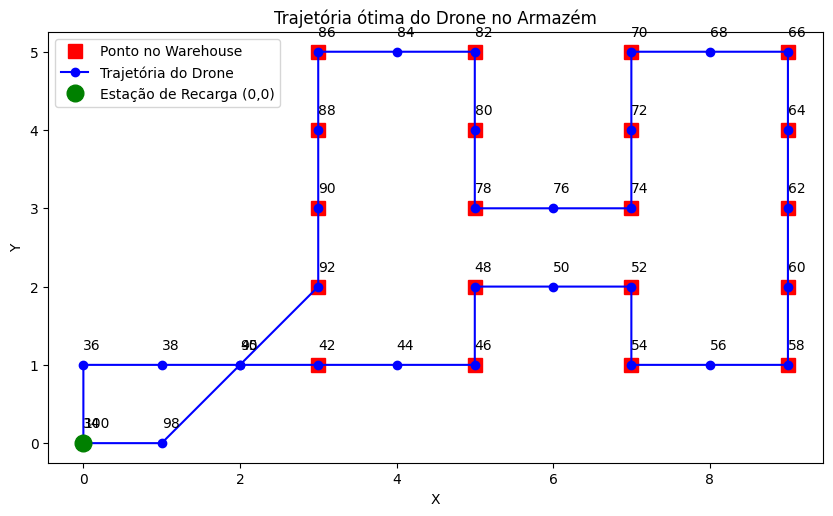

In [5]:
from z3 import *  # Importa todas as funções, classes e objetos do módulo Z3 para resolução de problemas de restrições e lógica
import matplotlib.pyplot as plt  # Importa o módulo pyplot da biblioteca matplotlib para criação e exibição de gráficos

def find_minimum_timesteps(max_timesteps, bmax, gridx, gridy, warehouse):  # Define a função que busca o menor número de timesteps viáveis para visitar todos os pontos do warehouse
    """
    Procura, com um solver simples, o menor número de timesteps em que
    existe uma solução viável que visita todos os pontos do warehouse.
    """  # Documentação explicativa da função
    for timesteps in range(1, max_timesteps + 1):  # Itera de 1 até max_timesteps para testar diferentes números de timesteps
        s = Solver()  # Cria uma nova instância do solver do Z3 para o número atual de timesteps

        # Declaração das variáveis para cada timestep
        PGx = [Int(f'pgx_{k}') for k in range(timesteps)]  # Cria uma lista de variáveis inteiras para a coordenada x do drone em cada timestep
        PGy = [Int(f'pgy_{k}') for k in range(timesteps)]  # Cria uma lista de variáveis inteiras para a coordenada y do drone em cada timestep
        Bat = [Int(f'bat_{k}') for k in range(timesteps)]  # Cria uma lista de variáveis inteiras para o nível de bateria do drone em cada timestep

        # Restrições de limites para as variáveis
        for b in Bat:  # Para cada variável representando a bateria
            s.add(And(b >= 1, b <= bmax))  # Adiciona a restrição de que a bateria deve estar entre 1 e bmax (inclusive)
        for x in PGx:  # Para cada variável representando a posição x
            s.add(And(x >= 0, x <= gridx))  # Adiciona a restrição de que a coordenada x deve estar entre 0 e gridx (inclusive)
        for y in PGy:  # Para cada variável representando a posição y
            s.add(And(y >= 0, y <= gridy))  # Adiciona a restrição de que a coordenada y deve estar entre 0 e gridy (inclusive)

        # Condições iniciais
        s.add(PGx[0] == 0, PGy[0] == 0, Bat[0] == bmax)  # Define as condições iniciais: o drone começa na posição (0,0) com a bateria cheia (bmax)

        # Restrições de movimento e consumo de bateria
        for k in range(1, timesteps):  # Para cada timestep a partir do 1 até o final
            s.add(Or(PGx[k] == PGx[k-1] + 1, PGx[k] == PGx[k-1] - 1, PGx[k] == PGx[k-1]))  # Restringe o movimento na coordenada x: pode avançar, retroceder ou permanecer
            s.add(Or(PGy[k] == PGy[k-1] + 1, PGy[k] == PGy[k-1] - 1, PGy[k] == PGy[k-1]))  # Restringe o movimento na coordenada y: pode subir, descer ou permanecer
            
            # Impede que o drone permaneça na mesma posição
            s.add(Not(And(PGx[k] == PGx[k-1], PGy[k] == PGy[k-1])))  # Garante que o drone se mova, impedindo que ambas as coordenadas não mudem
            
            s.add(If(  # Adiciona uma condição para definir o consumo de bateria baseado no tipo de movimento; a função If do Z3 avalia a condição e retorna o segundo argumento se verdadeira ou o terceiro se falsa
                Or(  # Condição: verifica se o movimento é diagonal (ambas as coordenadas mudam)
                    And(PGx[k] == PGx[k-1] + 1, PGy[k] == PGy[k-1] + 1),  # Movimento diagonal: para cima à direita
                    And(PGx[k] == PGx[k-1] - 1, PGy[k] == PGy[k-1] - 1),  # Movimento diagonal: para baixo à esquerda
                    And(PGx[k] == PGx[k-1] + 1, PGy[k] == PGy[k-1] - 1),  # Movimento diagonal: para baixo à direita
                    And(PGx[k] == PGx[k-1] - 1, PGy[k] == PGy[k-1] + 1)   # Movimento diagonal: para cima à esquerda
                ),  # Fim da condição para movimento diagonal
                Bat[k] == Bat[k-1] - 3,  # Se o movimento for diagonal, a bateria diminui em 3 unidades
                If(  # Se a condição anterior não for satisfeita, verifica se o movimento é horizontal ou vertical
                    Or(  # Condição: verifica se o movimento é horizontal ou vertical (apenas uma coordenada muda)
                        And(PGx[k] == PGx[k-1] + 1, PGy[k] == PGy[k-1]),  # Movimento horizontal: para a direita
                        And(PGx[k] == PGx[k-1] - 1, PGy[k] == PGy[k-1]),  # Movimento horizontal: para a esquerda
                        And(PGx[k] == PGx[k-1], PGy[k] == PGy[k-1] - 1),  # Movimento vertical: para baixo
                        And(PGx[k] == PGx[k-1], PGy[k] == PGy[k-1] + 1)   # Movimento vertical: para cima
                    ),  # Fim da condição para movimento horizontal/vertical
                    Bat[k] == Bat[k-1] - 2,  # Se o movimento for horizontal ou vertical, a bateria diminui em 2 unidades
                    Bat[k] == Bat[k-1]  # Se nenhuma das condições for satisfeita, a bateria não é alterada
                )  # Fim do segundo If
            ))  # Fim do primeiro If e da restrição de consumo de bateria

        # Cada ponto no warehouse deve ser visitado em algum timestep
        for (x, y) in warehouse:  # Para cada ponto (x, y) presente no warehouse
            s.add(Or([And(PGx[k] == x, PGy[k] == y) for k in range(timesteps)]))  # Adiciona a restrição de que, para cada ponto, existe ao menos um timestep em que o drone esteja na posição (x, y)
        
        # Adicionando restrição para que, no último timestep, o drone retorne ao ponto inicial (0,0)
        s.add(PGx[timesteps - 1] == 0)  # Restringe que a posição x no último timestep seja 0 (retorno à origem)
        s.add(PGy[timesteps - 1] == 0)  # Restringe que a posição y no último timestep seja 0 (retorno à origem)
        
        if s.check() == sat:  # Verifica se o solver encontrou uma solução viável para este número de timesteps
            print(s.check(), "timesteps:", timesteps)  # Imprime o resultado da verificação (sat) e o número de timesteps
            result = timesteps  # Armazena o número de timesteps como resultado viável
        else:  # Caso a solução não seja viável
            print(s.check(), "timesteps:", timesteps)  # Imprime o resultado da verificação (unsat) e o número de timesteps
            result = None  # Define o resultado como None para este número de timesteps
    return result  # Retorna o menor número de timesteps viável (ou None se nenhum for encontrado)

def optimize_battery(timesteps, bmax, gridx, gridy, warehouse):  # Define a função que otimiza o nível de bateria final para um número fixo de timesteps
    """
    Com um número fixo de timesteps (mínimo encontrado), configura as
    restrições e usa o Optimize para maximizar a bateria no último passo.
    """  # Documentação explicativa da função
    opt = Optimize()  # Cria uma instância do otimizador do Z3 para maximizar a bateria final

    PGx = [Int(f'pgx_{k}') for k in range(timesteps)]  # Cria uma lista de variáveis inteiras para a coordenada x do drone para cada timestep
    PGy = [Int(f'pgy_{k}') for k in range(timesteps)]  # Cria uma lista de variáveis inteiras para a coordenada y do drone para cada timestep
    Bat = [Int(f'bat_{k}') for k in range(timesteps)]  # Cria uma lista de variáveis inteiras para o nível de bateria do drone para cada timestep

    for b in Bat:  # Para cada variável representando a bateria
        opt.add(And(b >= 1, b <= bmax))  # Adiciona a restrição de que o nível de bateria deve estar entre 1 e bmax
    for x in PGx:  # Para cada variável representando a posição x
        opt.add(And(x >= 0, x <= gridx))  # Adiciona a restrição de que a coordenada x deve estar entre 0 e gridx
    for y in PGy:  # Para cada variável representando a posição y
        opt.add(And(y >= 0, y <= gridy))  # Adiciona a restrição de que a coordenada y deve estar entre 0 e gridy

    opt.add(PGx[0] == 0, PGy[0] == 0, Bat[0] == bmax)  # Define as condições iniciais: o drone inicia na posição (0,0) com a bateria cheia (bmax)

    for k in range(1, timesteps):  # Para cada timestep a partir do 1 até o final
        # Restrições de movimento permitidas para cada coordenada
        opt.add(Or(PGx[k] == PGx[k-1] + 1, PGx[k] == PGx[k-1] - 1, PGx[k] == PGx[k-1]))  # Restringe o movimento na coordenada x: pode avançar, retroceder ou permanecer
        opt.add(Or(PGy[k] == PGy[k-1] + 1, PGy[k] == PGy[k-1] - 1, PGy[k] == PGy[k-1]))  # Restringe o movimento na coordenada y: pode subir, descer ou permanecer
        
        # Impede que o drone permaneça parado (ambas as coordenadas iguais ao timestep anterior)
        opt.add(Not(And(PGx[k] == PGx[k-1], PGy[k] == PGy[k-1])))  # Garante que o drone se mova em cada timestep

        # Restrições de consumo de bateria com base no tipo de movimento
        opt.add(If(  # Adiciona uma restrição condicional para determinar o consumo de bateria com base no movimento realizado
            Or(  # Verifica se o movimento é diagonal (mudança em ambas as coordenadas)
                And(PGx[k] == PGx[k-1] + 1, PGy[k] == PGy[k-1] + 1),  # Diagonal: para cima à direita
                And(PGx[k] == PGx[k-1] - 1, PGy[k] == PGy[k-1] - 1),  # Diagonal: para baixo à esquerda
                And(PGx[k] == PGx[k-1] + 1, PGy[k] == PGy[k-1] - 1),  # Diagonal: para baixo à direita
                And(PGx[k] == PGx[k-1] - 1, PGy[k] == PGy[k-1] + 1)   # Diagonal: para cima à esquerda
            ),
            Bat[k] == Bat[k-1] - 3,  # Se o movimento for diagonal, a bateria diminui em 3 unidades
            If(  # Caso contrário, verifica se o movimento é horizontal ou vertical
                Or(  # Verifica os movimentos horizontais ou verticais
                    And(PGx[k] == PGx[k-1] + 1, PGy[k] == PGy[k-1]),  # Horizontal: para a direita
                    And(PGx[k] == PGx[k-1] - 1, PGy[k] == PGy[k-1]),  # Horizontal: para a esquerda
                    And(PGx[k] == PGx[k-1], PGy[k] == PGy[k-1] - 1),  # Vertical: para baixo
                    And(PGx[k] == PGx[k-1], PGy[k] == PGy[k-1] + 1)   # Vertical: para cima
                ),
                Bat[k] == Bat[k-1] - 2,  # Se o movimento for horizontal ou vertical, a bateria diminui em 2 unidades
                Bat[k] == Bat[k-1]  # Se nenhuma das condições se aplicar, a bateria permanece igual
            )
        ))  # Fim da restrição condicional de consumo de bateria

    for (x, y) in warehouse:  # Para cada ponto (x, y) do warehouse
        opt.add(Or([And(PGx[k] == x, PGy[k] == y) for k in range(timesteps)]))  # Garante que cada ponto do warehouse seja visitado em pelo menos um timestep

    # Adicionando restrição para que, no último timestep, o drone retorne ao ponto inicial (0,0)
    opt.add(PGx[timesteps - 1] == 0)  # Restringe que a posição x no último timestep seja 0 (retorno à origem)
    opt.add(PGy[timesteps - 1] == 0)  # Restringe que a posição y no último timestep seja 0 (retorno à origem)
    
    # Objetivo: maximizar a bateria no último timestep
    opt.maximize(Bat[timesteps - 1])  # Define que o objetivo é maximizar o valor da bateria no último timestep
    
    if opt.check() == sat:  # Verifica se a solução otimizada é satisfatível
        m = opt.model()  # Obtém o modelo (solução) otimizado
        melhor_bateria = m.evaluate(Bat[timesteps - 1]).as_long()  # Avalia e obtém o valor da bateria no último timestep do modelo
        return m, PGx, PGy, Bat, melhor_bateria  # Retorna o modelo, as variáveis e o valor da melhor bateria encontrada
    return None, None, None, None, None  # Se a otimização não for satisfatível, retorna None para todos os valores

# Parâmetros do problema
max_timesteps = 33  # Define o limite superior para a busca de timesteps
bmax = 100  # Define a capacidade máxima da bateria
gridx = 12  # Define o limite da grade no eixo x
gridy = 10  # Define o limite da grade no eixo y

# Fase 1: Encontra o menor número de timesteps com uma solução viável
min_timesteps = find_minimum_timesteps(max_timesteps, bmax, gridx, gridy, warehouse)  # Chama a função para encontrar o menor número de timesteps possível
if min_timesteps is None:  # Verifica se nenhum número viável de timesteps foi encontrado
    print("Nenhuma solução encontrada até", max_timesteps, "timesteps.")  # Informa que nenhuma solução foi encontrada dentro do limite máximo
else:  # Caso contrário, se uma solução viável foi encontrada
    print(f"Solução viável encontrada com {min_timesteps} timesteps.")  # Imprime o número de timesteps com solução viável
    
    # Fase 2: Com o número mínimo de timesteps, otimiza para maximizar a bateria final
    modelo, PGx, PGy, Bat, melhor_bateria = optimize_battery(min_timesteps, bmax, gridx, gridy, warehouse)  # Chama a função que otimiza o nível de bateria no último timestep
    if modelo:  # Se o modelo otimizado foi obtido com sucesso
        print("\nTrajetória com maior bateria final:", melhor_bateria)  # Imprime o valor da maior bateria final encontrado
        pgx_values = [modelo.evaluate(PGx[k]).as_long() for k in range(min_timesteps)]  # Extrai os valores de posição x do modelo para cada timestep
        pgy_values = [modelo.evaluate(PGy[k]).as_long() for k in range(min_timesteps)]  # Extrai os valores de posição y do modelo para cada timestep
        bat_values = [modelo.evaluate(Bat[k]).as_long() for k in range(min_timesteps)]  # Extrai os valores de bateria do modelo para cada timestep
        
        print("\nTrajetória ótima:")  # Imprime um cabeçalho para a trajetória ótima
        for t in range(min_timesteps):  # Para cada timestep na trajetória ótima
            print(f"Passo {t}: Posição ({pgx_values[t]}, {pgy_values[t]}), Bateria {bat_values[t]}")  # Imprime os detalhes do passo: posição e bateria
        
        # Visualização da trajetória
        fig, ax = plt.subplots(figsize=(10, 6))  # Cria uma figura e eixos para o gráfico com tamanho 10x6
        # Plotando os pontos do warehouse
        for i, (x, y) in enumerate(warehouse):  # Itera pelos pontos do warehouse com seus índices
            if i == 0:  # Se for o primeiro ponto
                ax.plot(x, y, 'rs', markersize=10, label="Ponto no Warehouse")  # Plota o ponto com marcador vermelho quadrado, tamanho 10, e adiciona um label
            else:  # Para os demais pontos
                ax.plot(x, y, 'rs', markersize=10)  # Plota o ponto com marcador vermelho quadrado, tamanho 10, sem label
        # Plotando a trajetória do drone
        ax.plot(pgx_values, pgy_values, 'b-o', label="Trajetória do Drone")  # Plota a trajetória do drone com linha azul e marcadores circulares, adicionando um label
        ax.plot(0, 0, 'go', markersize=12, label="Estação de Recarga (0,0)")  # Plota o ponto (0,0) com marcador verde, tamanho 12, e adiciona um label para a estação de recarga
        for t in range(min_timesteps):  # Itera por cada timestep para adicionar anotações de bateria
            ax.text(pgx_values[t], pgy_values[t] + 0.2, f'{bat_values[t]}', fontsize=10)  # Adiciona texto próximo ao ponto indicando o valor da bateria, com pequeno deslocamento vertical
        plt.xlabel("X")  # Define o rótulo do eixo x do gráfico
        plt.ylabel("Y")  # Define o rótulo do eixo y do gráfico
        plt.title("Trajetória ótima do Drone no Armazém")  # Define o título do gráfico
        plt.legend()  # Exibe a legenda do gráfico para identificar os elementos
        ax.set_aspect('equal')  # Ajusta a proporção dos eixos para que as escalas de x e y sejam iguais
        plt.show()  # Exibe o gráfico com a trajetória ótima do drone
    else:  # Se o modelo otimizado não foi obtido
        print("Falha na otimização da bateria.")  # Imprime uma mensagem indicando a falha na otimização da bateria
